# Multiprocessing Module

- If your job can be split to run on multiple CPUs without too much engineering effort, then this is a wise direction to consider.

- When used to parallelize a problem over a set of CPUs you can expect up to an n-times (nx) speedup with n cores. If you have a quad-core machine and you can use all four cores for your task, it might run in a quarter of the original runtime. You are unlikely to see a greater than 4x speedup; in practice, you’ll probably see gains of 3–4x.

- Each additional process will increase the communication overhead and decrease the available RAM, so you rarely get a full nx speedup. Depending on which problem you are solving, the communication overhead can even get so large that you can see very significant slowdowns.

- To parallelize your task, you have to think a little differently to the normal way of writing a serial process. You must also accept that debugging a parallelized task is harder—often, it can be very frustrating. We’d recommend keeping the parallelism as simple as possible

- Avoiding shared state will make your life far easier.

- For example, if we can have multiple Python processes all solving the same problem without communicating with one another (a situation known as embarrassingly parallel), not much of a penalty will be incurred as we add more and more Python processes.

- On the other hand, if each process needs to communicate with every other Python process, the communication overhead will slowly overwhelm the processing and slow things down. This means that as we add more and more Python processes, we can actually slow down our overall performance.

## Estimating Pi using the Monte Carlo method

- Using one thread takes approximately 120 seconds. 
- Using two or more threads takes longer. 
- By using two or more processes, we make the runtime shorter. 
- The cost of using no processes or threads (the series implementation) is the same as running with one process.

**Remember**:
- If we’re using threads each instruction is bound by the GIL, so although each thread could run on a separate CPU, it will only execute when no other threads are running. 
- The process version is not bound by this restriction, as each forked process has a private Python interpreter running as a single thread—there’s no GIL contention as no objects are shared.

### Use Pure Python

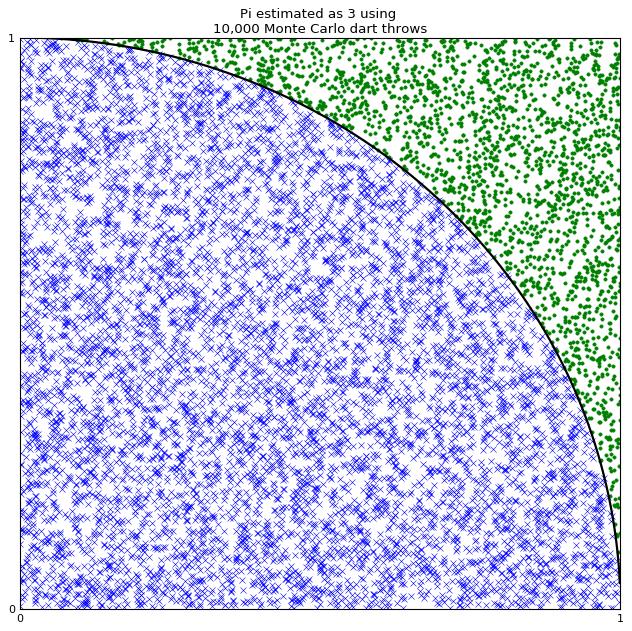

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


if __name__ == "__main__":
    np.random.seed(0)  # force repeatable plt
    nbr_items = int(1e4)
    xs = np.random.uniform(0, 1, nbr_items)
    ys = np.random.uniform(0, 1, nbr_items)
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    nbr_trials_in_quarter_unit_circle = np.sum(
        estimate_inside_quarter_unit_circle)
    # estimate for the full circle
    pi = (nbr_trials_in_quarter_unit_circle * 4) / nbr_items

    plt.figure(1, figsize=(8, 8))
    plt.clf()
    plt.plot(xs[estimate_inside_quarter_unit_circle],
             ys[estimate_inside_quarter_unit_circle], 'bx')
    plt.plot(xs[estimate_inside_quarter_unit_circle == False],
             ys[estimate_inside_quarter_unit_circle == False], 'g.')

    unit_circle_xs = np.arange(0, 1, 0.001)
    unit_circle_ys = np.sin(np.arccos(unit_circle_xs))
    plt.plot(unit_circle_xs, unit_circle_ys, linewidth=2, c="k")
    plt.xticks([0.0, 1.0])
    plt.yticks([0.0, 1.0])
    plt.title("Pi estimated as {} using \n{:,} Monte Carlo dart throws".format(
        pi, int(nbr_items)))
    # plt.show()
    plt.tight_layout()
    plt.show()

In [ ]:
import random
import time
import argparse


def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    nbr_trials_in_quarter_unit_circle = 0
    for step in xrange(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle

    return nbr_trials_in_quarter_unit_circle


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Project description')
    parser.add_argument(
        'nbr_workers', type=int, help='Number of workers e.g. 1, 2, 4, 8')
    parser.add_argument(
        '--nbr_samples_in_total',
        type=int,
        default=1e8,
        help='Number of samples in total e.g. 100000000')
    parser.add_argument(
        '--processes',
        action="store_true",
        default=False,
        help='True if using Processes, absent (False) for Threads')

    args = parser.parse_args()
    if args.processes:
        print "Using Processes"
        from multiprocessing import Pool
    else:
        print "Using Threads"
        from multiprocessing.dummy import Pool

    nbr_samples_in_total = args.nbr_samples_in_total  # should be 1e8
    nbr_parallel_blocks = args.nbr_workers
    pool = Pool(processes=nbr_parallel_blocks)
    nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
    print "Making {} samples per {} worker".format(nbr_samples_per_worker, nbr_parallel_blocks)
    nbr_trials_per_process = [nbr_samples_per_worker] * nbr_parallel_blocks
    t1 = time.time()
    nbr_in_quarter_unit_circles = pool.map(
        estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    pi_estimate = sum(nbr_in_quarter_unit_circles) * \
        4 / float(nbr_samples_in_total)
    print "Estimated pi", pi_estimate
    print "Delta:", time.time() - t1

In [ ]:
# time python list_parallel.py 1 --processe
Using Processes
Making 100000000.0 samples per 1 worker
Estimated pi 3.14156204
Delta: 73.4828960896

real	1m13.622s
user	1m13.574s
sys	0m0.029s

# time python list_parallel.py 2 --processe
Using Processes
Making 50000000.0 samples per 2 worker
Estimated pi 3.14172456
Delta: 36.6343078613

real	0m36.782s
user	1m13.327s
sys	0m0.034s

# time python list_parallel.py 4 --processe
Using Processes
Making 25000000.0 samples per 4 worker
Estimated pi 3.14147612
Delta: 19.9739699364

real	0m20.129s
user	1m17.991s
sys	0m0.043s

# time python list_parallel.py 8 --processe
Using Processes
Making 12500000.0 samples per 8 worker
Estimated pi 3.1414888
Delta: 10.7293329239

real	0m10.904s
user	1m24.118s
sys	0m0.071s

# time python list_parallel.py 16 --processe
Using Processes
Making 6250000.0 samples per 16 worker
Estimated pi 3.14158308
Delta: 8.40494585037

real	0m8.517s
user	1m36.556s
sys	0m0.088s

# This is the real core of this machine, more than that is fake, no improvement!
#time python list_parallel.py 32 --processe
Using Processes
Making 3125000.0 samples per 32 worker
Estimated pi 3.14151452
Delta: 6.47379279137

real	0m6.619s
user	3m11.007s
sys	0m0.353s

#time python list_parallel.py 64 --processe
Using Processes
Making 1562500.0 samples per 64 worker
Estimated pi 3.14191444
Delta: 6.46806907654

real	0m6.673s
user	3m9.749s
sys	0m0.617s

### Using Numpy

- The serial and single-worker versions execute at the same speed—there’s no overhead to using *threads* with numpy

- The threaded version runs faster with more threads—this is the opposite behavior to the pure Python case, where threads made the example run slower. As discussed on the SciPy wiki, by working outside of the GIL numpy can achieve some level of additional speedup around threads.

- Note that the random number generator is seeded when this function is called. For the threaded version this isn’t nec‐essary, as each thread shares the same random number generator and they access it in series. For the process version, as each new process is a fork, all the forked versions will share the same state. This means the random number calls in each will return the same sequence! Calling seed() should ensure that each of the forked processes generates a unique sequence of random numbers.

In [10]:
"""Estimate Pi using blocks of serial work on 1 CPU"""
import time
#from multiprocessing.dummy import Pool
import numpy as np


def estimate_nbr_points_in_circle(nbr_samples):
    # set random seed for numpy in each new process
    # else the fork will mean they all share the same state
    np.random.seed()
    xs = np.random.uniform(0, 1, nbr_samples)
    ys = np.random.uniform(0, 1, nbr_samples)
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    nbr_trials_in_quarter_unit_circle = np.sum(
        estimate_inside_quarter_unit_circle)
    return nbr_trials_in_quarter_unit_circle


if __name__ == "__main__":
    nbr_samples_in_total = int(1e8)

    nbr_parallel_blocks = 4
    nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
    print "Making {} samples per worker".format(nbr_samples_per_worker)

    t1 = time.time()
    nbr_in_circle = 0
    for npb in xrange(nbr_parallel_blocks):
        nbr_in_circle += estimate_nbr_points_in_circle(nbr_samples_per_worker)
    print "Took {}s".format(time.time() - t1)
    pi_estimate = float(nbr_in_circle) / nbr_samples_in_total * 4
    print "Estimated pi", pi_estimate
    print "Pi", np.pi

Making 25000000 samples per worker
Took 8.31170415878s
Estimated pi 3.14174452
Pi 3.14159265359


In [ ]:
"""Estimate Pi using Threads and Processes"""
import time
import argparse
import numpy as np


def estimate_nbr_points_in_quarter_circle(nbr_samples):
    np.random.seed()
    xs = np.random.uniform(0, 1, nbr_samples)
    ys = np.random.uniform(0, 1, nbr_samples)
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    nbr_trials_in_quarter_unit_circle = np.sum(
        estimate_inside_quarter_unit_circle)
    return nbr_trials_in_quarter_unit_circle


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Project description')
    parser.add_argument(
        'nbr_workers', type=int, help='Number of workers e.g. 1, 2, 4, 8')
    parser.add_argument(
        '--nbr_samples_in_total',
        type=int,
        default=1e8,
        help='Number of samples in total e.g. 100000000')
    parser.add_argument(
        '--processes',
        action="store_true",
        default=False,
        help='True if using Processes, absent (False) for Threads')

    args = parser.parse_args()
    if args.processes:
        print "Using Processes"
        from multiprocessing import Pool
    else:
        print "Using Threads"
        from multiprocessing.dummy import Pool

    nbr_samples_in_total = args.nbr_samples_in_total  # should be 1e8
    nbr_parallel_blocks = args.nbr_workers

    pool = Pool()

    nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
    print "Making {} samples per worker".format(nbr_samples_per_worker)

    # confirm we have an integer number of jobs to distribute
    assert nbr_samples_per_worker == int(nbr_samples_per_worker)
    nbr_samples_per_worker = int(nbr_samples_per_worker)
    map_inputs = [nbr_samples_per_worker] * nbr_parallel_blocks
    t1 = time.time()
    results = pool.map(estimate_nbr_points_in_quarter_circle, map_inputs)
    pool.close()
    print "Dart throws in unit circle per worker:", results
    print "Took {}s".format(time.time() - t1)
    nbr_in_circle = sum(results)
    combined_nbr_samples = sum(map_inputs)

    pi_estimate = float(nbr_in_circle) / combined_nbr_samples * 4
    print "Estimated pi", pi_estimate
    print "Pi", np.pi

In [ ]:
# python list_numpy_parallel.py 1 --processes
Using Processes
Making 100000000.0 samples per worker
Took 10.1875650883s
Estimated pi 3.14182404
Pi 3.14159265359

# python list_numpy_parallel.py 2 --processes
Using Processes
Making 50000000.0 samples per worker
Took 8.11004805565s
Estimated pi 3.14156632
Pi 3.14159265359

# python list_numpy_parallel.py 4 --processes
Using Processes
Making 25000000.0 samples per worker
Took 4.7323679924s
Estimated pi 3.14158812
Pi 3.14159265359

# python list_numpy_parallel.py 8 --processes
Using Processes
Making 12500000.0 samples per worker
Took 3.90301680565s
Estimated pi 3.14153132
Pi 3.14159265359

# python list_numpy_parallel.py 16 --processes
Using Processes
Making 6250000.0 samples per worker
Took 3.25118923187s
Estimated pi 3.14161476
Pi 3.14159265359

# python list_numpy_parallel.py 32 --processes
Using Processes
Making 3125000.0 samples per worker
Took 2.9905090332s
Estimated pi 3.14162964
Pi 3.14159265359

# python list_numpy_parallel.py 64 --processes
Using Processes
Making 1562500.0 samples per worker
Took 2.30734014511s
Estimated pi 3.14159012
Pi 3.14159265359

# python list_numpy_parallel.py 128 --processes
Using Processes
Making 781250.0 samples per worker
Took 1.98235607147s
Estimated pi 3.14138048
Pi 3.14159265359

# python list_numpy_parallel.py 256 --processes
Using Processes
Making 390625.0 samples per worker
Took 1.05464196205s
Estimated pi 3.1417364
Pi 3.14159265359

# python list_numpy_parallel.py 1
Using Threads
Making 100000000.0 samples per worker
Took 10.9700379372s
Estimated pi 3.1414758
Pi 3.14159265359

# python list_numpy_parallel.py 2
Using Threads
Making 50000000.0 samples per worker
Took 9.28233003616s
Estimated pi 3.14163848
Pi 3.14159265359

# python list_numpy_parallel.py 4
Using Threads
Making 25000000.0 samples per worker
Took 8.89052796364s
Estimated pi 3.14174012
Pi 3.14159265359

# Cannot improve more from here
# python list_numpy_parallel.py 8
Using Threads
Making 12500000.0 samples per worker
Took 8.89019489288s
Estimated pi 3.1415066
Pi 3.14159265359